In [18]:
import pymysql
import pandas as pd

In [19]:
db_name = 'hr'
db_host = 'localhost'
db_username = 'root'
db_password = 'kiranprm11mysql'

In [20]:
try:
    conn = pymysql.connect(host = db_host,
                            port = int(3307),
                            user = 'root',
                            passwd = db_password,
                            db = db_name)
except e:
    print(e)

### PLAYING WITH CODE AND WINDOW FUCTION 

In [21]:
pd.read_sql_query('''



SELECT 
    MAX(salary) AS max_salary 
FROM employees


''', conn)


,max_salary
0,25000


- only gave the max salary and nothing else 

In [22]:
pd.read_sql_query('''



SELECT 
    d.department_name,
    MAX(salary) AS max_salary 
FROM employees e
JOIN departments d
ON e.department_id = d.department_id
GROUP BY d.department_name 


''', conn)


,department_name,max_salary
0,Executive,25000
1,IT,9000
2,Finance,12000
3,Purchasing,11000
4,Shipping,8200
5,Sales,14000
6,Administration,4400
7,Marketing,13000
8,Human Resources,6500
9,Public Relations,10000


- able to extract the max salary of each departments 
- but the issue is what if we want to extract all the other details of employeess as well with it ??
- there we use OVER fn 

In [28]:
pd.read_sql_query('''



SELECT 
    employee_id,
    first_name,
    d.department_name,
    MAX(salary) OVER() AS max_salary 
FROM employees e
JOIN departments d
ON e.department_id = d.department_id


''', conn)

,employee_id,first_name,department_name,max_salary
0,100,Steven,Executive,25000
1,101,Neena,Executive,25000
2,102,Lex,Executive,25000
3,103,Alexander,IT,25000
4,104,Bruce,IT,25000
...,...,...,...,...
101,202,Pat,Marketing,25000
102,203,Susan,Human Resources,25000
103,204,Hermann,Public Relations,25000
104,205,Shelley,Accounting,25000


- for all of this 106 records the max salary is computed for the whole table and put as 25000

max salary for each department

In [30]:
pd.read_sql_query('''



SELECT 
    employee_id,
    first_name,
    d.department_name,
    MAX(salary) OVER(partition by department_name) AS max_salary 
FROM employees e
JOIN departments d
ON e.department_id = d.department_id


''', conn)

,employee_id,first_name,department_name,max_salary
0,205,Shelley,Accounting,12000
1,206,William,Accounting,12000
2,200,Jennifer,Administration,4400
3,100,Steven,Executive,25000
4,101,Neena,Executive,25000
...,...,...,...,...
101,141,Trenna,Shipping,8200
102,139,John,Shipping,8200
103,138,Stephen,Shipping,8200
104,137,Renske,Shipping,8200


#### more examples on window fuctions 

Row_number 

In [31]:
pd.read_sql_query('''



SELECT 
    employee_id,
    first_name,
    d.department_name,
    row_number() OVER() AS rn 
FROM employees e
JOIN departments d
ON e.department_id = d.department_id


''', conn)

,employee_id,first_name,department_name,rn
0,100,Steven,Executive,1
1,101,Neena,Executive,2
2,102,Lex,Executive,3
3,103,Alexander,IT,4
4,104,Bruce,IT,5
...,...,...,...,...
101,202,Pat,Marketing,102
102,203,Susan,Human Resources,103
103,204,Hermann,Public Relations,104
104,205,Shelley,Accounting,105


- for each row a unique number was assigned because the over () was empty so that the whole table was considered by the window fuction as one table 

if we want to get it numbered according to departments then

In [33]:
pd.read_sql_query('''



SELECT 
    employee_id,
    first_name,
    d.department_name,
     row_number() OVER(partition by department_name) AS rn 
FROM employees e
JOIN departments d
ON e.department_id = d.department_id


''', conn).head(10)

,employee_id,first_name,department_name,rn
0,205,Shelley,Accounting,1
1,206,William,Accounting,2
2,200,Jennifer,Administration,1
3,100,Steven,Executive,1
4,101,Neena,Executive,2
5,102,Lex,Executive,3
6,108,Nancy,Finance,1
7,109,Daniel,Finance,2
8,110,John,Finance,3
9,111,Ismael,Finance,4


- the row numbers are resetting every time the departments are changing 

how can this be useful ??
- to know the first 2 employee who joined a department ?? - USE ORDER BY 


In [41]:
pd.read_sql_query('''



SELECT 
    employee_id,
    first_name,
    d.department_name,
     row_number() OVER(partition by department_name order by employee_id) AS rn 
FROM employees e
JOIN departments d
ON e.department_id = d.department_id


''', conn).head(10)

,employee_id,first_name,department_name,rn
0,205,Shelley,Accounting,1
1,206,William,Accounting,2
2,200,Jennifer,Administration,1
3,100,Steven,Executive,1
4,101,Neena,Executive,2
5,102,Lex,Executive,3
6,108,Nancy,Finance,1
7,109,Daniel,Finance,2
8,110,John,Finance,3
9,111,Ismael,Finance,4


- here the results shows the order alone but not the first 2. for that we need to use this whole query as a sub query

In [39]:
pd.read_sql_query('''


SELECT * FROM


    (SELECT 
        employee_id,
        first_name,
        d.department_name,
         row_number() OVER(partition by department_name order by employee_id) AS rn 
    FROM employees e
    JOIN departments d
    ON e.department_id = d.department_id) AS x
    
    
WHERE x.rn < 3

''', conn)

,employee_id,first_name,department_name,rn
0,205,Shelley,Accounting,1
1,206,William,Accounting,2
2,200,Jennifer,Administration,1
3,100,Steven,Executive,1
4,101,Neena,Executive,2
5,108,Nancy,Finance,1
6,109,Daniel,Finance,2
7,203,Susan,Human Resources,1
8,103,Alexander,IT,1
9,104,Bruce,IT,2


- now i only have 18 rows instead of 106 earlier 
-  here i have only top 2 employees joined first 

RANK

- lets find the top 3 employee with max salary in each department 

In [50]:
pd.read_sql_query('''



SELECT 
    employee_id,
    first_name,
    salary,
    d.department_name,
     RANK() OVER(partition by department_name order by salary DESC) AS rnk 
FROM employees e
JOIN departments d
ON e.department_id = d.department_id


''', conn).head(20)

,employee_id,first_name,salary,department_name,rnk
0,205,Shelley,12000,Accounting,1
1,206,William,8300,Accounting,2
2,200,Jennifer,4400,Administration,1
3,100,Steven,25000,Executive,1
4,101,Neena,17000,Executive,2
5,102,Lex,17000,Executive,2
6,108,Nancy,12000,Finance,1
7,109,Daniel,9000,Finance,2
8,110,John,8200,Finance,3
9,112,Jose Manuel,7800,Finance,4


- here we can see that there are same ranks for same salary people 
- for every duplicate value , when the change occures the counts skips the values and jumps to next -  it should be 1 2 3 4 5 but instead it is 12 3 3 5
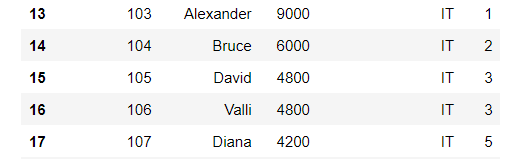

our q is emp with top 3 salary in each department 

In [51]:
pd.read_sql_query('''


SELECT * FROM 


(SELECT 
    employee_id,
    first_name,
    salary,
    d.department_name,
     RANK() OVER(partition by department_name order by salary DESC) AS rnk 
FROM employees e
JOIN departments d
ON e.department_id = d.department_id
) AS x


WHERE x.rnk < 4

''', conn).head(20)

,employee_id,first_name,salary,department_name,rnk
0,205,Shelley,12000,Accounting,1
1,206,William,8300,Accounting,2
2,200,Jennifer,4400,Administration,1
3,100,Steven,25000,Executive,1
4,101,Neena,17000,Executive,2
5,102,Lex,17000,Executive,2
6,108,Nancy,12000,Finance,1
7,109,Daniel,9000,Finance,2
8,110,John,8200,Finance,3
9,203,Susan,6500,Human Resources,1


DENSE RANK()

In [56]:
pd.read_sql_query('''

SELECT 
    employee_id,
    first_name,
    salary,
    d.department_name,
     RANK() OVER(partition by department_name order by salary DESC) AS rnk,
     DENSE_RANK() OVER(partition by department_name order by salary DESC) AS dense_rnk 
FROM employees e
JOIN departments d
ON e.department_id = d.department_id





''', conn).head(20)

,employee_id,first_name,salary,department_name,rnk,dense_rnk
0,205,Shelley,12000,Accounting,1,1
1,206,William,8300,Accounting,2,2
2,200,Jennifer,4400,Administration,1,1
3,100,Steven,25000,Executive,1,1
4,101,Neena,17000,Executive,2,2
5,102,Lex,17000,Executive,2,2
6,108,Nancy,12000,Finance,1,1
7,109,Daniel,9000,Finance,2,2
8,110,John,8200,Finance,3,3
9,112,Jose Manuel,7800,Finance,4,4


- instead of 1 2 3 3 5 in rank we can get 1 2 3 3 4 in dense rank. which will be useful to know the actual position when compared with others with equal salary rather than just positions 
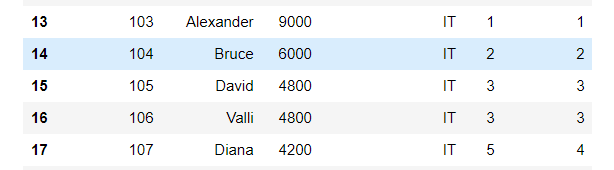

#### DIFFERENCE BETWEEN RANK , DENSE RANK & ROW NUMBER  

In [58]:
pd.read_sql_query('''

SELECT 
    employee_id,
    first_name,
    salary,
    d.department_name,
     RANK() OVER(partition by department_name order by salary DESC) AS rnk,
     DENSE_RANK() OVER(partition by department_name order by salary DESC) AS dense_rnk,
     ROW_NUMBER() OVER(partition by department_name order by salary DESC) AS rn
FROM employees e
JOIN departments d
ON e.department_id = d.department_id





''', conn).head(20)

,employee_id,first_name,salary,department_name,rnk,dense_rnk,rn
0,205,Shelley,12000,Accounting,1,1,1
1,206,William,8300,Accounting,2,2,2
2,200,Jennifer,4400,Administration,1,1,1
3,100,Steven,25000,Executive,1,1,1
4,101,Neena,17000,Executive,2,2,2
5,102,Lex,17000,Executive,2,2,3
6,108,Nancy,12000,Finance,1,1,1
7,109,Daniel,9000,Finance,2,2,2
8,110,John,8200,Finance,3,3,3
9,112,Jose Manuel,7800,Finance,4,4,4


- this is the difference between all RANK , DENSE RANK & ROW NUMBER 
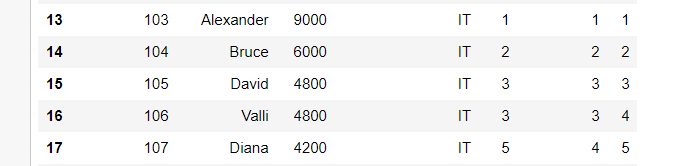 

#### LAG FUNCTION 

- check if the salary of a current employee is greater than or lesser than or equal to the previous employee 

In [61]:
pd.read_sql_query('''

SELECT 
    employee_id,
    first_name,
    d.department_name,
    salary,
    LAG(salary) OVER(partition by department_name order by employee_id) AS previous_salary
FROM employees e
JOIN departments d
ON e.department_id = d.department_id





''', conn).head(20)

,employee_id,first_name,department_name,salary,previous_salary
0,205,Shelley,Accounting,12000,NaN
1,206,William,Accounting,8300,12000.0
2,200,Jennifer,Administration,4400,NaN
3,100,Steven,Executive,25000,NaN
4,101,Neena,Executive,17000,25000.0
5,102,Lex,Executive,17000,17000.0
6,108,Nancy,Finance,12000,NaN
7,109,Daniel,Finance,9000,12000.0
8,110,John,Finance,8200,9000.0
9,111,Ismael,Finance,7700,8200.0


- here we got the employee salary of the previous employee 
- we can get the next employee salary with lead function 
- we can change the syntax like LAG(salary , 2 , 0) - 2 is how many above i have to look to fetch a data and 0 is with what i have to fill in case there is nothing.

In [63]:
pd.read_sql_query('''

SELECT 
    employee_id,
    first_name,
    d.department_name,
    salary,
    LAG(salary) OVER(partition by department_name order by employee_id) AS previous_salary,
    salary,
    LEAD(salary) OVER(partition by department_name order by employee_id) AS next_salary
FROM employees e
JOIN departments d
ON e.department_id = d.department_id





''', conn).head(20)

,employee_id,first_name,department_name,salary,previous_salary,salary,next_salary
0,205,Shelley,Accounting,12000,NaN,12000,8300.0
1,206,William,Accounting,8300,12000.0,8300,NaN
2,200,Jennifer,Administration,4400,NaN,4400,NaN
3,100,Steven,Executive,25000,NaN,25000,17000.0
4,101,Neena,Executive,17000,25000.0,17000,17000.0
5,102,Lex,Executive,17000,17000.0,17000,NaN
6,108,Nancy,Finance,12000,NaN,12000,9000.0
7,109,Daniel,Finance,9000,12000.0,9000,8200.0
8,110,John,Finance,8200,9000.0,8200,7700.0
9,111,Ismael,Finance,7700,8200.0,7700,7800.0


- but the question remains ,  how to check if its lower , higher or equal ??
- for that we need to use partition along with case when 

In [69]:
pd.read_sql_query('''

SELECT 
    employee_id,
    first_name,
    d.department_name,
    salary,
    LAG(salary) OVER(partition by department_name order by employee_id) AS previous_salary,
    CASE 
        WHEN e.salary > LAG(salary) OVER(partition by department_name order by employee_id) THEN 'higher than previos employee'
        WHEN e.salary < LAG(salary) OVER(partition by department_name order by employee_id) THEN 'lower than previos employee'
        WHEN e.salary = LAG(salary) OVER(partition by department_name order by employee_id) THEN 'same as previos employee'
    END AS salary_range
FROM employees e
JOIN departments d
ON e.department_id = d.department_id





''', conn).head(20)

,employee_id,first_name,department_name,salary,previous_salary,salary_range
0,205,Shelley,Accounting,12000,NaN,None
1,206,William,Accounting,8300,12000.0,lower than previos employee
2,200,Jennifer,Administration,4400,NaN,None
3,100,Steven,Executive,25000,NaN,None
4,101,Neena,Executive,17000,25000.0,lower than previos employee
5,102,Lex,Executive,17000,17000.0,same as previos employee
6,108,Nancy,Finance,12000,NaN,None
7,109,Daniel,Finance,9000,12000.0,lower than previos employee
8,110,John,Finance,8200,9000.0,lower than previos employee
9,111,Ismael,Finance,7700,8200.0,lower than previos employee
